ref. [Timeseries classification with a Transformer model](https://keras.io/examples/timeseries/timeseries_classification_transformer/)

transformer의 encoder 부분만 떼고, 그 뒤에 DSA 분류 층을 붙여서 분류하기

https://machinelearningmastery.com/wp-content/uploads/2021/10/transformer_1.png

즉 위 링크의 transformer 사진에서 좌측의 Nx 빨간 네모 부분만 사용한 것임. 해당 예제는 NLP와 같은 데이터가 아니기 때문에 워드임베딩 및 포지셔널 임베딩은 필요없음.

기본적인 transformer는 attention에만 의존하기 때문에, 제대로 된 성능을 내려면 데이터가 매우 많이 필요함.

따라서 transformer의 인코더 뒤에 CNN을 붙이거나 하면 데이터가 비교적 적어도 좋은 성능을 냄.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./datasets/DSA_features.csv')
df

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,people
0,7.975714,8.1605,7.6823,0.014395,0.119981,-0.023319,1.083150,1.1832,0.99744,0.002208,...,0.000792,0.177075,-0.057119,-0.054963,-0.059241,6.778722e-07,0.000823,0.036729,sitting,p1
1,7.978250,8.1763,7.8472,0.007551,0.086896,0.552416,1.140865,1.2129,1.05810,0.000784,...,0.000860,-0.286918,-0.057268,-0.054945,-0.059589,7.032302e-07,0.000839,0.347471,sitting,p1
2,7.970894,8.0860,7.8470,0.003092,0.055603,0.100538,1.140962,1.2128,1.07960,0.000508,...,0.000762,-0.134430,-0.057068,-0.054711,-0.059065,6.268222e-07,0.000792,0.045579,sitting,p1
3,7.938412,8.1083,7.6901,0.003763,0.061343,-0.231914,1.165260,1.3170,1.07870,0.002173,...,0.000735,0.021485,-0.056422,-0.053670,-0.058310,8.011245e-07,0.000895,0.240690,sitting,p1
4,7.908930,8.1305,7.8322,0.001741,0.041731,2.042285,1.187504,1.2574,1.09450,0.000662,...,0.000824,-0.148229,-0.055801,-0.053313,-0.057815,6.853423e-07,0.000828,0.258429,sitting,p1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9115,8.280854,34.1980,-2.9038,28.080803,5.299132,1.350075,-1.491537,11.2240,-11.65100,14.670334,...,0.200829,-0.040701,0.297666,0.708480,-0.117430,4.135451e-02,0.203358,-0.310022,basketBall,p8
9116,9.591118,51.6970,-3.4129,35.722025,5.976791,2.981144,0.086304,6.9951,-11.76400,5.329897,...,0.148745,-0.266377,0.224716,0.554670,-0.250950,3.355704e-02,0.183186,-0.736410,basketBall,p8
9117,9.599113,27.9300,-1.0765,48.850886,6.989341,0.449237,-0.728367,3.7801,-8.36910,5.683022,...,0.310748,-0.009505,-0.237786,0.088854,-0.477260,2.026107e-02,0.142341,0.668438,basketBall,p8
9118,9.692482,72.7820,-2.6734,59.378336,7.705734,4.491114,-0.582724,6.1216,-8.85710,4.162963,...,0.156493,0.050624,0.533023,0.677800,0.055941,1.356379e-02,0.116464,-1.482489,basketBall,p8


In [3]:
# string -> int로 바꾸는 LabelEncoder 사용
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['activity'] = label_encoder.fit_transform(df['activity'])

# 별도의 LabelEncoder 객체를 사용해야 함
label_encoder = LabelEncoder()
df['activity'] = label_encoder.fit_transform(df['activity'])

In [4]:
X = df.drop(['activity', 'people'], axis=1).to_numpy()
y = df['activity'].to_numpy()

In [5]:
# train, test 분리
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=42)

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
# Sequential dataset 만들기
from collections import Counter

def split_sequences_classification_majority(data, labels, n_steps):
    """
    비연속 데이터셋을 일정한 길이의 연속적인 시퀀스로 변환하는 함수
    window에서 다수를 차지하는 label로 결정
    
    Args:
    data: 원본 데이터 (리스트 또는 배열)
    labels: 각 데이터에 해당하는 클래스 라벨 (리스트 또는 배열)
    n_steps: 시퀀스의 길이 (정수)
    
    Returns:
    X: 입력 시퀀스
    y: 해당 시퀀스에 대한 다수 라벨
    """
    X, y = [], []
    
    for i in range(len(data) - n_steps + 1):
        # 시퀀스 추출
        seq_x = data[i:i + n_steps]
        seq_labels = labels[i:i + n_steps]
        
        # 시퀀스의 라벨 중 가장 빈번한 라벨을 선택 (다수결)
        most_common_label = Counter(seq_labels).most_common(1)[0][0]
        
        X.append(seq_x)
        y.append(most_common_label)
    
    return np.array(X), np.array(y)

In [8]:
n_steps = 3
X_train_seq, y_train_seq = split_sequences_classification_majority(X_train,
                                                                   y_train,
                                                                   n_steps)
X_test_seq, y_test_seq = split_sequences_classification_majority(X_test,
                                                                 y_test,
                                                                 n_steps)

print(f"X_train_seq.shape: {X_train_seq.shape}", end=" ")
print(f"y_train_seq.shape: {y_train_seq.shape}")
print(f"X_test_seq.shape: {X_test_seq.shape}", end=" ")
print(f"y_test_seq.shape: {y_test_seq.shape}")

X_train_seq.shape: (6838, 3, 270) y_train_seq.shape: (6838,)
X_test_seq.shape: (2278, 3, 270) y_test_seq.shape: (2278,)


In [9]:
# one-hot encoding
from keras.utils import to_categorical

y_train_seq = to_categorical(y_train_seq)
y_test_seq = to_categorical(y_test_seq)

print("==== one-hot encoded ====")
print(f"y_train_seq.shape: {y_train_seq.shape}")
print(f"y_test_seq.shape: {y_test_seq.shape}")

2024-10-10 11:14:57.625420: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


==== one-hot encoded ====
y_train_seq.shape: (6838, 19)
y_test_seq.shape: (2278, 19)


# Build the model

In [10]:
import tensorflow as tf
import tensorflow.keras as keras

In [11]:
# def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
#     """
#     num_heads: multi-head attention에서 head의 수 지정
#     """
#     # Attention and Normalization
#     x = layers.MultiHeadAttention(
#         key_dim=head_size, num_heads=num_heads, dropout=dropout
#     )(inputs, inputs)
#     x = layers.Dropout(dropout)(x)
#     x = layers.LayerNormalization(epsilon=1e-6)(x)
#     res = x + inputs # skip connection

#     # Feed Forward Part
#     x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
#     x = layers.Dropout(dropout)(x)
#     x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
#     x = layers.LayerNormalization(epsilon=1e-6)(x)
#     return x + res

In [12]:
# model = keras.Sequential()

# encoder_block = transformer_encoder((3, 270), 270, 3, 
# model.add(transformer

In [13]:
# def build_model(
#     input_shape,
#     head_size,
#     num_heads,
#     ff_dim,
#     num_transformer_blocks,
#     mlp_units,
#     dropout=0,
#     mlp_dropout=0,
# ):
#     inputs = keras.Input(shape=input_shape)
#     x = inputs
#     for _ in range(num_transformer_blocks):
#         x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

#     x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
#     for dim in mlp_units:
#         x = layers.Dense(dim, activation="relu")(x)
#         x = layers.Dropout(mlp_dropout)(x)
#     outputs = layers.Dense(n_classes, activation="softmax")(x)
#     return keras.Model(inputs, outputs)

# Train and evaluate

In [14]:
# input_shape = x_train.shape[1:]

# model = build_model(
#     input_shape,
#     head_size=256,
#     num_heads=4,
#     ff_dim=4,
#     num_transformer_blocks=4, # encoder block 몇 번 반복할건지, 소요 시간을 늘어나게 하는 주범
#     mlp_units=[128],
#     mlp_dropout=0.4,
#     dropout=0.25,
# )

# model.compile(
#     loss="sparse_categorical_crossentropy",
#     optimizer=keras.optimizers.Adam(learning_rate=1e-4),
#     metrics=["sparse_categorical_accuracy"],
# )
# model.summary()

# callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

# model.fit(
#     x_train,
#     y_train,
#     validation_split=0.2,
#     epochs=150,
#     batch_size=64,
#     callbacks=callbacks,
# )

# model.evaluate(x_test, y_test, verbose=1)

In [15]:
from tensorflow import keras
from tensorflow.keras import layers

# Transformer Encoder block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    """
    num_heads: multi-head attention에서 head의 수 지정
    """
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs  # Skip connection
    
    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

# Building the full model
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    n_classes,   # Number of output classes
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)  # input_shape = (3, 270)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    
    # Global Average Pooling to reduce the dimensions
    x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
    
    # Dense MLP layers
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)

    ###added
    # Output layer for classification with 19 classes
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    
    return keras.Model(inputs, outputs)

# Define model parameters
input_shape = (3, 270)
head_size = 64
num_heads = 4
ff_dim = 128
num_transformer_blocks = 3 # 많을수록 학습 시간 오래 걸림
mlp_units = [128, 64]
n_classes = 19  # for y_train_seq shape (6838, 19)
dropout = 0.1
mlp_dropout = 0.1

# Build and compile the model
model = build_model(input_shape, head_size, num_heads, ff_dim, 
                    num_transformer_blocks, mlp_units, n_classes, 
                    dropout, mlp_dropout)

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",  # Assuming you have one-hot encoded y_train_seq
    metrics=["accuracy"]
)

# Check model summary
model.summary()


2024-10-10 11:15:01.989705: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, 270)]     0           []                               
                                                                                                  
 multi_head_attention (MultiHea  (None, 3, 270)      277518      ['input_1[0][0]',                
 dAttention)                                                      'input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 3, 270)       0           ['multi_head_attention[0][0]']   
                                                                                                  
 layer_normalization (LayerNorm  (None, 3, 270)      540         ['dropout[0][0]']            

In [16]:
history = model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=256, validation_split=0.1, shuffle=True)

Epoch 1/50
25/25 [==============================] - 5s 89ms/step - loss: 3.7864 - accuracy: 0.1090 - val_loss: 2.7461 - val_accuracy: 0.1637
Epoch 2/50
25/25 [==============================] - 2s 71ms/step - loss: 2.6890 - accuracy: 0.1895 - val_loss: 2.5721 - val_accuracy: 0.2558
Epoch 3/50
25/25 [==============================] - 2s 72ms/step - loss: 2.5253 - accuracy: 0.2329 - val_loss: 2.4176 - val_accuracy: 0.2734
Epoch 4/50
25/25 [==============================] - 2s 66ms/step - loss: 2.4056 - accuracy: 0.2548 - val_loss: 2.2509 - val_accuracy: 0.3114
Epoch 5/50
25/25 [==============================] - 2s 64ms/step - loss: 2.3365 - accuracy: 0.2740 - val_loss: 2.1928 - val_accuracy: 0.3260
Epoch 6/50
25/25 [==============================] - 2s 69ms/step - loss: 2.2250 - accuracy: 0.2876 - val_loss: 2.0495 - val_accuracy: 0.3450
Epoch 7/50
25/25 [==============================] - 2s 64ms/step - loss: 2.1252 - accuracy: 0.3190 - val_loss: 1.9826 - val_accuracy: 0.3436
Epoch 8/50
25

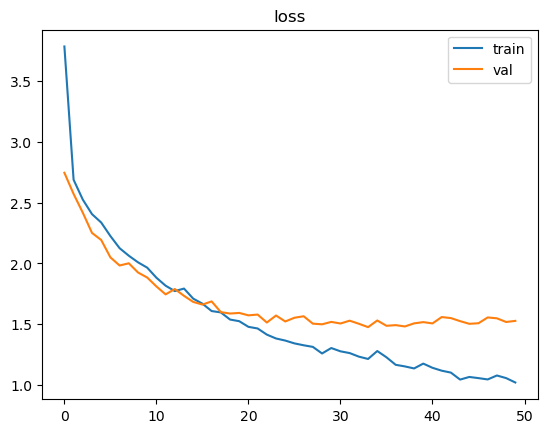

In [17]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'val')
plt.title('loss')
plt.legend()

In [18]:
model.evaluate(X_train_seq, y_train_seq)

214/214 [==============================] - 1s 7ms/step - loss: 0.8270 - accuracy: 0.6691


[0.8270406723022461, 0.6690552830696106]

In [19]:
model.evaluate(X_test_seq, y_test_seq)

72/72 [==============================] - 1s 7ms/step - loss: 1.4411 - accuracy: 0.4192


[1.4410605430603027, 0.41922739148139954]

72/72 [==============================] - 1s 4ms/step
Confusion Matrix


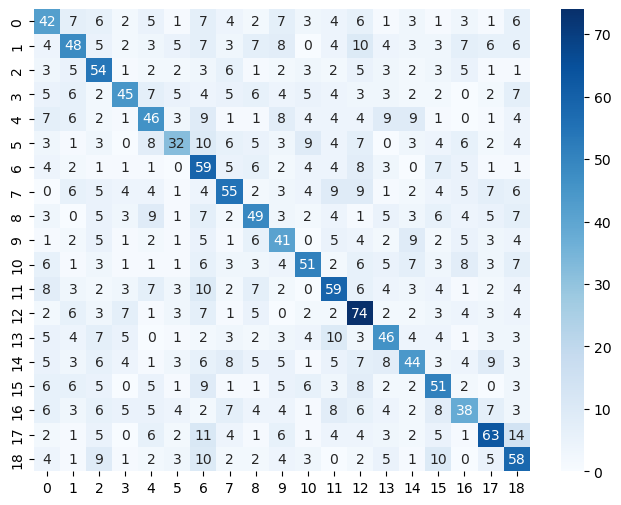

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

y_test_arg=np.argmax(y_test_seq, axis=1)
Y_pred = np.argmax(model.predict(X_test_seq),axis=1)
print('Confusion Matrix')
cm = confusion_matrix(y_test_arg, Y_pred)
# 시각화
plt.figure(figsize=(8, 6))  # 그래프 크기 조절 (너비 8, 높이 6)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# 그래프 표시
plt.show()